# New York City Taxi Fare Prediction


![](https://media.timeout.com/images/105785000/image.jpg)
We'll train a machine learning model to predict the fare for a taxi ride in New York city given information like pickup date & time, pickup location, drop location and no. of passengers. 

Dataset Link: https://www.kaggle.com/c/new-york-city-taxi-fare-prediction


## 1. Download the Dataset

- Install required libraries
- Download data from Kaggle
- View dataset files
- Load training set with Pandas
- Load test set with Pandas



Dataset link: https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/overview



In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import os
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import opendatasets as od 
%matplotlib inline

### Install Required Libraries

In [2]:
!pip install numpy pandas jovian opendatasets scikit-learn xgboost --quiet

### Download Data from Kaggle

We'll use the opendatasets library: https://github.com/JovianML/opendatasets

In [3]:
import opendatasets as od

In [4]:
dataset_url = 'https://www.kaggle.com/competitions/new-york-city-taxi-fare-prediction/overview'

In [5]:
%%time
od.download(dataset_url,data_dir='../Datasets')

Skipping, found downloaded files in "../Datasets\new-york-city-taxi-fare-prediction" (use force=True to force download)
CPU times: total: 0 ns
Wall time: 0 ns


In [6]:
data_dir = '../Datasets/new-york-city-taxi-fare-prediction'

### View Dataset Files

In [7]:
train_df_1000000 = pd.read_csv(data_dir+"/train.csv",nrows=1000000)

In [8]:
train_df_1000000.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [9]:
train_df_1000000.columns

Index(['key', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count'],
      dtype='object')

Observations:

- This is a supervised learning regression problem
- Training data is 5.5 GB in size
- Training data has 5.5 million rows
- Test set is much smaller (< 10,000 rows)
- The training set has 8 columns:
    - `key` (a unique identifier)
    - `fare_amount` (target column)
    - `pickup_datetime`
    - `pickup_longitude`
    - `pickup_latitude`
    - `dropoff_longitude`
    - `dropoff_latitude`
    - `passenger_count`
- The test set has all columns except the target column `fare_amount`.
- The submission file should contain the `key` and `fare_amount` for each test sample.



In [10]:
train_df_1000000.dtypes

key                   object
fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

### Loading Training Set

Loading the entire dataset into Pandas is going to be slow, so we can use the following optimizations:

- Ignore the `key` column
- Parse pickup datetime while loading data 
- Specify data types for other columns
   - `float32` for geo coordinates
   - `float32` for fare amount
   - `uint8` for passenger count          ---------------   As it must be a single numeric value
- Work with a 1% sample of the data (~500k rows)

We can apply these optimizations while using [`pd.read_csv`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html)

In [11]:
# Include Columns as per our requirement
selected_cols = 'fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count'.split(',')
selected_cols

['fare_amount',
 'pickup_datetime',
 'pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude',
 'passenger_count']

In [12]:
# Set Datatypes of our columns
dtypes = {
    'fare_amount': 'float32',
    'pickup_longitude': 'float32',
    'pickup_latitude': 'float32',
    'dropoff_longitude': 'float32',
    'dropoff_latitude' : 'float32',
    'passenger_count': 'uint8'
}

# Pandas Read function (Advanced)

- Pick selected columns from csv
- dtype converstion of selected columns
- parse datettime column from UTC to +0.00
- select randomize data

In [13]:
%%time 
# Select limited random rows from dataset

sample_frac = 0.09
def skip_row(row_idx):
    if row_idx == 0:            
        return False
    return random.random() > sample_frac   

random.seed(42)                    
df = pd.read_csv(data_dir+"/train.csv", 
                 usecols=selected_cols, 
                 dtype=dtypes, 
                 parse_dates=['pickup_datetime'], 
                 skiprows=skip_row)

CPU times: total: 3min 36s
Wall time: 3min 43s


In [14]:
df.shape

(830241, 7)

In [15]:
df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.0,2014-12-06 20:36:22+00:00,-73.979813,40.751904,-73.979446,40.755482,1
1,10.0,2014-11-12 12:40:29+00:00,-74.002579,40.739571,-73.994583,40.760681,1
2,8.0,2013-01-17 17:22:00+00:00,0.000000,0.000000,0.000000,0.000000,2
3,8.9,2011-06-15 18:07:00+00:00,-73.996330,40.753223,-73.978897,40.766964,3
4,6.9,2009-12-14 12:33:00+00:00,-73.982430,40.745747,-73.982430,40.745747,1


### Load Test Set

For the test set, we'll simply provide the data types.

In [16]:
test_df = pd.read_csv(data_dir+'/test.csv', dtype=dtypes, parse_dates=['pickup_datetime'])

## 2. Explore the Dataset

- Basic info about training set
- Basic info about test set
- Exploratory data analysis & visualization
- Ask & answer questions

### Training Set

In [17]:
import missingno as msgn

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 830241 entries, 0 to 830240
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   fare_amount        830241 non-null  float32            
 1   pickup_datetime    830241 non-null  datetime64[ns, UTC]
 2   pickup_longitude   830241 non-null  float32            
 3   pickup_latitude    830241 non-null  float32            
 4   dropoff_longitude  830239 non-null  float32            
 5   dropoff_latitude   830239 non-null  float32            
 6   passenger_count    830241 non-null  uint8              
dtypes: datetime64[ns, UTC](1), float32(5), uint8(1)
memory usage: 23.0 MB


<AxesSubplot:>

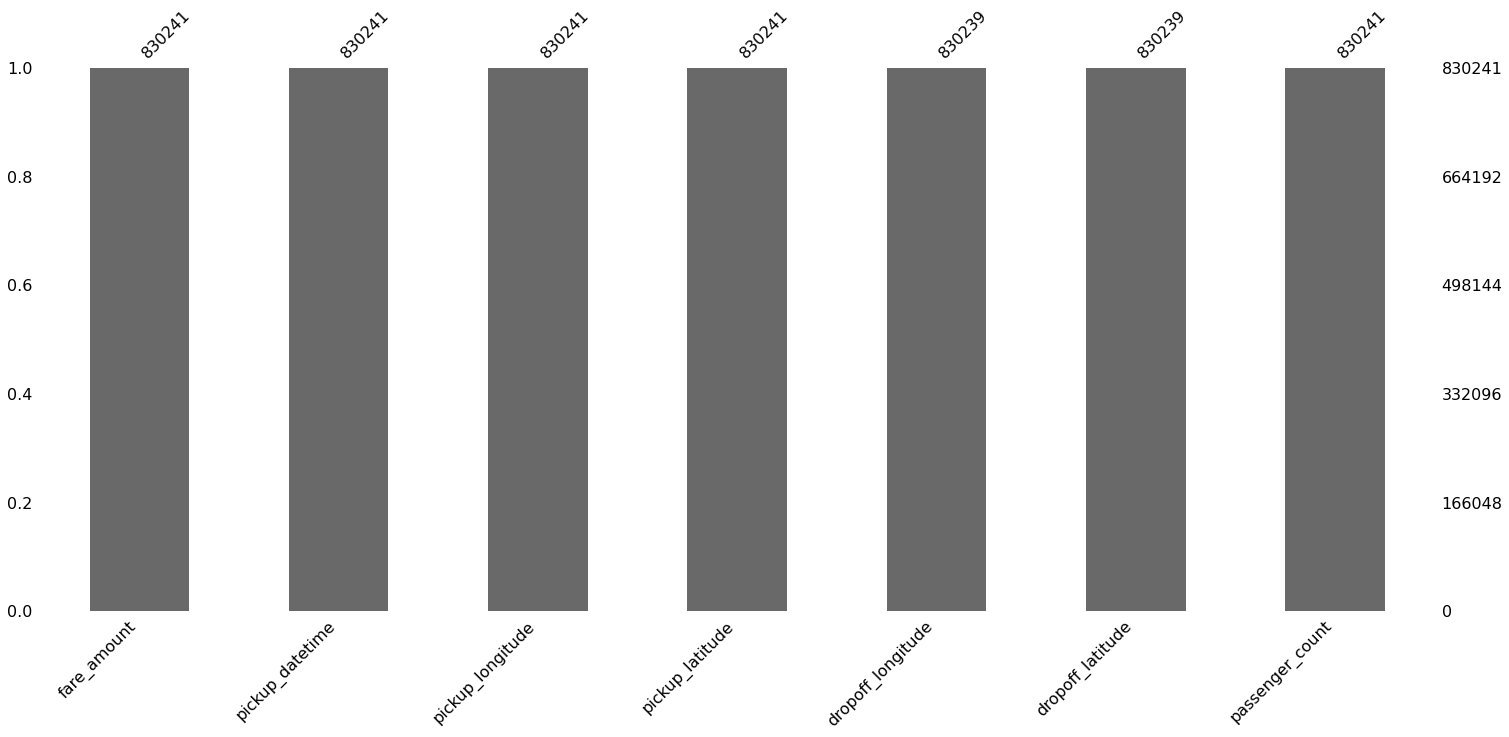

In [19]:
msgn.bar(df)

In [20]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,830241.000000,830241.000000,830241.000000,830239.000000,830239.000000,830241.000000
mean,11.346478,-72.503807,39.915577,-72.513351,39.930012,1.683936
std,9.787337,11.798507,8.703607,12.537702,8.977443,1.326036
min,-52.000000,-2027.098999,-3084.490234,-3356.729736,-2173.847900,0.000000
25%,6.000000,-73.992027,40.734867,-73.991409,40.733959,1.000000
50%,8.500000,-73.981796,40.752617,-73.980186,40.753120,1.000000
75%,12.500000,-73.967140,40.767052,-73.963699,40.768108,2.000000
max,499.000000,2420.209473,2560.142578,3440.820312,3351.403076,208.000000


In [21]:
df.pickup_datetime[:2]

0   2014-12-06 20:36:22+00:00
1   2014-11-12 12:40:29+00:00
Name: pickup_datetime, dtype: datetime64[ns, UTC]

In [22]:
df.pickup_datetime.min(), df.pickup_datetime.max()

(Timestamp('2009-01-01 00:11:46+0000', tz='UTC'),
 Timestamp('2015-06-30 23:59:54+0000', tz='UTC'))

**Exploring skewness of the fare_amount

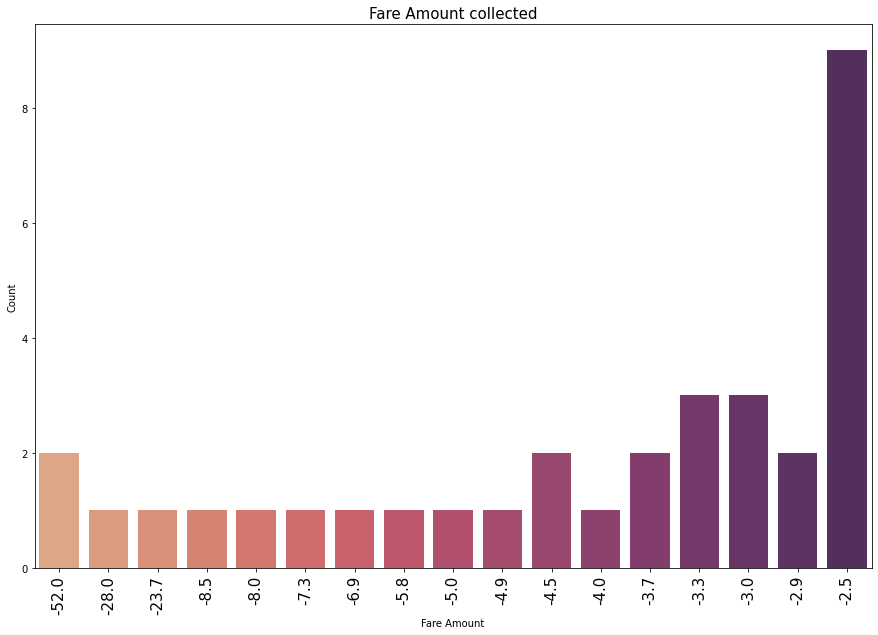

In [23]:
plt.figure(figsize=(15,10))
sns.countplot(x='fare_amount',data=df[df['fare_amount']<0], palette='flare')
plt.title("Fare Amount collected",fontsize=15)
loc, labels = plt.xticks()
plt.xlabel('Fare Amount',fontsize = 10)
plt.ylabel('Count',fontsize = 10)
plt.xticks(fontsize=15,rotation='vertical')
plt.show()

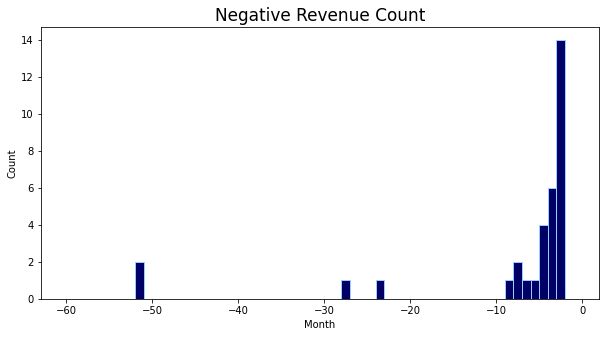

In [24]:
plt.figure(figsize=(10,5))
plt.hist(x='fare_amount', data=df ,bins=np.arange(-60,0,1),edgecolor='#99ccff',color='#000066')
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Negative Revenue Count', fontsize=17);

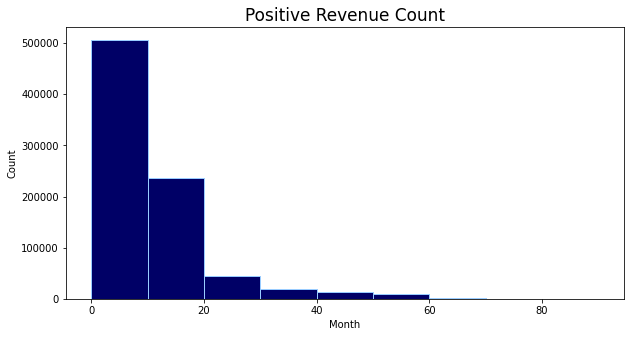

In [25]:
plt.figure(figsize=(10,5))
plt.hist(x='fare_amount', data=df,bins=np.arange(0,100,10),edgecolor='#99ccff',color='#000066')
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Positive Revenue Count', fontsize=17);

In [26]:
df.passenger_count.value_counts()

1      574490
2      122423
5       58793
3       36597
4       17644
6       17365
0        2927
7           1
208         1
Name: passenger_count, dtype: int64

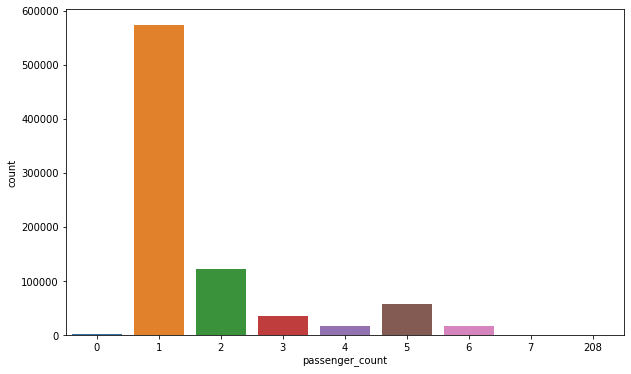

In [27]:
plt.figure(figsize=(10,6)) 
sns.countplot(x=df.passenger_count);

In [28]:
df.columns

Index(['fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count'],
      dtype='object')

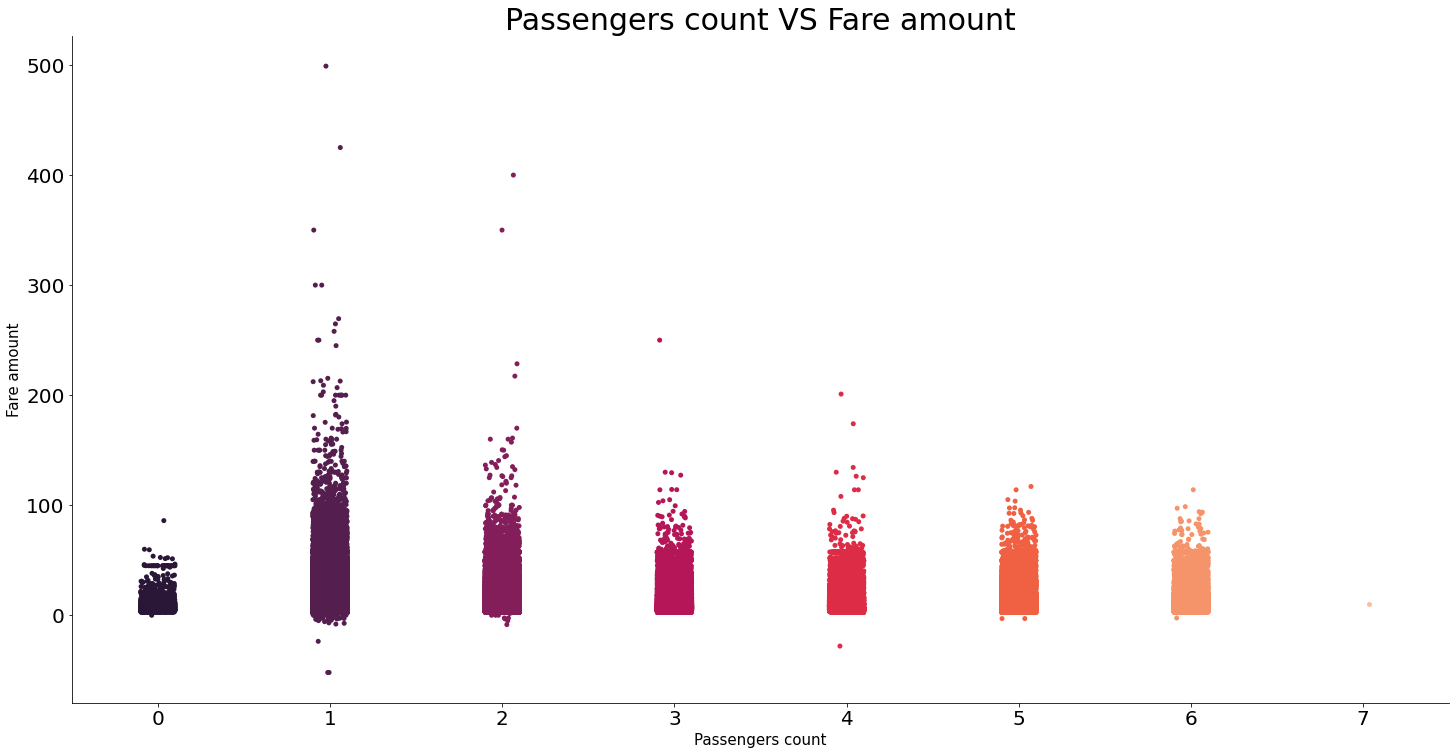

In [179]:
sns.catplot(x='passenger_count', y='fare_amount', data=df,palette='rocket',height=10, aspect=2)
plt.title('Passengers count VS Fare amount',fontsize=30); 
plt.xlabel('Passengers count',fontsize = 15 ) 
plt.xticks(fontsize=20)
plt.ylabel('Fare amount',fontsize = 15 )
plt.yticks(fontsize=20)
plt.show()

### Typecasting of longitude and latitude

In [30]:
df.pickup_longitude.apply(lambda x : int(x))

0        -73
1        -74
2          0
3        -73
4        -73
          ..
830236   -73
830237   -73
830238   -74
830239   -73
830240   -73
Name: pickup_longitude, Length: 830241, dtype: int64

In [31]:
df.dropoff_longitude.apply(lambda x : 0 if pd.isna(x) else int(x))

0        -73
1        -73
2          0
3        -73
4        -73
          ..
830236   -73
830237   -73
830238   -73
830239   -73
830240   -74
Name: dropoff_longitude, Length: 830241, dtype: int64

In [32]:
df.dropoff_latitude.apply(lambda x : 0 if pd.isna(x) else int(x))

0         40
1         40
2          0
3         40
4         40
          ..
830236    40
830237    40
830238    40
830239    40
830240    40
Name: dropoff_latitude, Length: 830241, dtype: int64

In [33]:
df.pickup_latitude.apply(lambda x : int(x))

0         40
1         40
2          0
3         40
4         40
          ..
830236    40
830237    40
830238    40
830239    40
830240    40
Name: pickup_latitude, Length: 830241, dtype: int64

Observations about training data:

- 550k+ rows, as expected
- No missing data (in the sample)
- `fare_amount` ranges from `$-52.0` to  `$499.0`
- `passenger_count` ranges from 0 to 208 
- There seem to be some errors in the latitude & longitude values
- Dates range from 1st Jan 2009 to 30th June 2015
- The dataset takes up ~19 MB of space in the RAM

We may need to deal with outliers and data entry errors before we train our model.


### Later we are analysing the same in Feature Engineering

#### Splitting out pickup_datetime into year , month , day of week , time

In [34]:
df.pickup_datetime.head()

0   2014-12-06 20:36:22+00:00
1   2014-11-12 12:40:29+00:00
2   2013-01-17 17:22:00+00:00
3   2011-06-15 18:07:00+00:00
4   2009-12-14 12:33:00+00:00
Name: pickup_datetime, dtype: datetime64[ns, UTC]

In [35]:
pd.to_datetime(df.pickup_datetime).dt.day_of_week.head()

0    5
1    2
2    3
3    2
4    0
Name: pickup_datetime, dtype: int64

- 0 --> Monday
- 6 --> Sunday

In [36]:
df['day']=pd.to_datetime(df.pickup_datetime).dt.dayofweek
df['month']=pd.to_datetime(df.pickup_datetime).dt.month;
df['year']=pd.to_datetime(df.pickup_datetime).dt.year;
df['time']=pd.to_datetime(df.pickup_datetime).dt.time


test_df['day']=pd.to_datetime(test_df.pickup_datetime).dt.dayofweek
test_df['month']=pd.to_datetime(test_df.pickup_datetime).dt.month;
test_df['year']=pd.to_datetime(test_df.pickup_datetime).dt.year;
test_df['time']=pd.to_datetime(test_df.pickup_datetime).dt.time

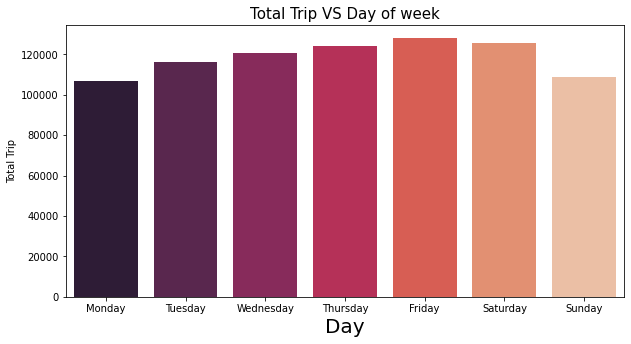

In [37]:
plt.figure(figsize=(10,5))
sns.countplot(x='day',data=df,palette="rocket")
loc, labels = plt.xticks()
loc, labels = loc, ['Monday','Tuesday','Wednesday','Thursday',"Friday","Saturday","Sunday"]
plt.xticks(loc, labels,fontsize=10)
plt.xlabel('Day',fontsize = 20)
plt.ylabel('Total Trip',fontsize = 10)
plt.title("Total Trip VS Day of week",fontsize=15)
plt.show()

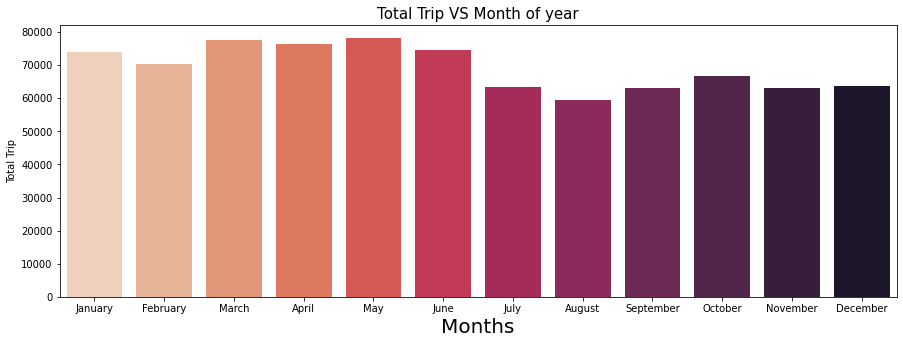

In [38]:
plt.figure(figsize=(15,5))
sns.countplot(x='month',data=df,palette="rocket_r")
loc, labels = plt.xticks()
loc, labels = loc,  ['January', 'February', 'March', 'April', 'May', 'June', 'July','August', 'September', 'October', 'November', 'December']
plt.xticks(loc, labels,fontsize=10)
plt.xlabel('Months',fontsize = 20)
plt.ylabel('Total Trip',fontsize = 10)
plt.title("Total Trip VS Month of year",fontsize=15)
plt.show()

# Creating Shifts

**Creating a new column `Shift` based on `Minutes`**

0 - Day shift (12am - 6pm)

1 - Night shift

In [39]:
df.time[0]

datetime.time(20, 36, 22)

In [40]:
# Converting time(hrs) to time(minutes) 
import datetime
t = df.time[0]
datetime.timedelta(hours=t.hour, minutes=t.minute, seconds=t.second).total_seconds()/60

1236.3666666666666

**Creating `Minutes` data column**

In [41]:
df['minutes']=df.time.apply(lambda x : datetime.timedelta(hours=x.hour, minutes=x.minute, seconds=x.second).total_seconds()/60)

In [42]:
df['minutes'][20:30]

20     705.200000
21     404.950000
22     501.000000
23     770.866667
24    1072.000000
25     158.000000
26    1070.000000
27     722.000000
28      22.483333
29    1083.116667
Name: minutes, dtype: float64

In [43]:
df['shift']=df.minutes.apply(lambda x : 0 if x<1080 else 1)

In [44]:
df['shift'][20:30]

20    0
21    0
22    0
23    0
24    0
25    0
26    0
27    0
28    0
29    1
Name: shift, dtype: int64

### Removing outlier of data

In [45]:
df[df.passenger_count==208]

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,day,month,year,time,minutes,shift
663236,2.5,2014-02-12 09:28:00+00:00,0.0,0.0,0.0,0.0,208,2,2,2014,09:28:00,568.0,0


In [46]:
df[df.passenger_count==208].index.values

array([663236], dtype=int64)

In [47]:
df.drop(df[df.passenger_count==208].index.values[0],inplace=True)
df[df.passenger_count==208]

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,day,month,year,time,minutes,shift


CPU times: total: 13.6 s
Wall time: 13.9 s


Text(0.5, 1.0, 'Passengers present vs Fare charges by Taxi based on shifts')

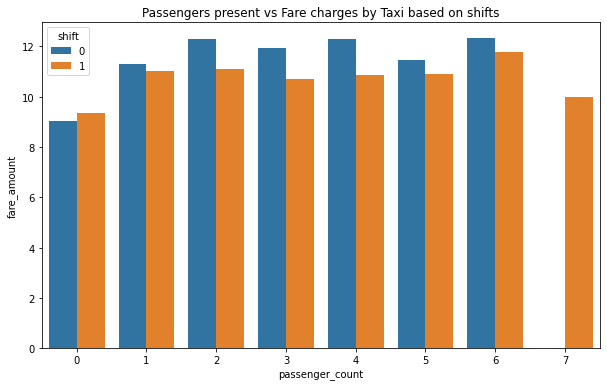

In [48]:
%%time
plt.figure(figsize=(10,6))
sns.barplot(data=df, x="passenger_count", y="fare_amount",hue='shift',ci=0);
plt.title("Passengers present vs Fare charges by Taxi based on shifts", fontweight=20)

### Test Set

In [49]:
test_df['shift']=test_df.time.apply(lambda x : datetime.timedelta(hours=x.hour, minutes=x.minute, seconds=x.second).total_seconds()/60).apply(lambda x : 0 if x<1080 else 1)

In [50]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9914 entries, 0 to 9913
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   key                9914 non-null   object             
 1   pickup_datetime    9914 non-null   datetime64[ns, UTC]
 2   pickup_longitude   9914 non-null   float32            
 3   pickup_latitude    9914 non-null   float32            
 4   dropoff_longitude  9914 non-null   float32            
 5   dropoff_latitude   9914 non-null   float32            
 6   passenger_count    9914 non-null   uint8              
 7   day                9914 non-null   int64              
 8   month              9914 non-null   int64              
 9   year               9914 non-null   int64              
 10  time               9914 non-null   object             
 11  shift              9914 non-null   int64              
dtypes: datetime64[ns, UTC](1), float32(4), int64(4),

In [51]:
test_df.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,day,month,year,shift
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,-73.974716,40.751041,-73.973656,40.751740,1.671273,2.852834,6.857979,2011.815816,0.354549
std,0.042774,0.033541,0.039072,0.035435,1.278747,1.994451,3.353272,1.803347,0.478401
min,-74.252190,40.573143,-74.263245,40.568974,1.000000,0.000000,1.000000,2009.000000,0.000000
25%,-73.992500,40.736125,-73.991249,40.735253,1.000000,1.000000,4.000000,2010.000000,0.000000
50%,-73.982327,40.753052,-73.980015,40.754065,1.000000,3.000000,7.000000,2012.000000,0.000000
75%,-73.968012,40.767113,-73.964062,40.768757,2.000000,5.000000,10.000000,2014.000000,1.000000
max,-72.986534,41.709557,-72.990967,41.696682,6.000000,6.000000,12.000000,2015.000000,1.000000


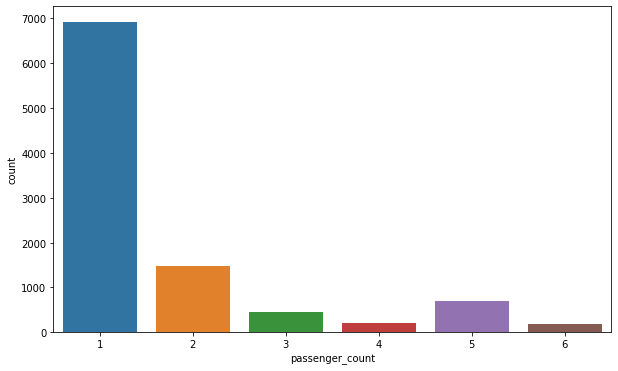

In [52]:
plt.figure(figsize=(10,6)) 
sns.countplot(x=test_df.passenger_count);

In [53]:
test_df.pickup_longitude.apply(lambda x : int(x)).value_counts()

-73    8529
-74    1384
-72       1
Name: pickup_longitude, dtype: int64

In [54]:
test_df.dropoff_longitude.apply(lambda x : int(x)).value_counts()

-73    8612
-74    1301
-72       1
Name: dropoff_longitude, dtype: int64

In [55]:
test_df.pickup_latitude.apply(lambda x : int(x)).value_counts()

40    9905
41       9
Name: pickup_latitude, dtype: int64

In [56]:
test_df.dropoff_latitude.apply(lambda x : int(x)).value_counts()

40    9908
41       6
Name: dropoff_latitude, dtype: int64

In [57]:
test_df.passenger_count

0       1
1       1
2       1
3       1
4       1
       ..
9909    6
9910    6
9911    6
9912    6
9913    6
Name: passenger_count, Length: 9914, dtype: uint8

In [58]:
test_df.pickup_datetime.min(), test_df.pickup_datetime.max()

(Timestamp('2009-01-01 11:04:24+0000', tz='UTC'),
 Timestamp('2015-06-30 20:03:50+0000', tz='UTC'))

Some observations about the test set:

- 9914 rows of data
- No missing values
- No obvious data entry errors
- 1 to 6 passengers (we can limit training data to this range)
- Latitudes lie between 40 and 42
- Longitudes lie between -75 and -72
- Pickup dates range from Jan 1st 2009 to Jun  30th 2015 (same as training set)

We can use the ranges of the test set to drop outliers/invalid data from the training set.

## 3. Prepare Dataset for Training

- Split Training & Validation Set
- Fill/Remove Missing Values
- Extract Inputs & Outputs
   - Training
   - Validation
   - Test

### Split Training & Validation Set

We'll set aside 20% of the training data as the validation set, to evaluate the models we train on previously unseen data. 

Since the test set and training set have the same date ranges, we can pick a random 20% fraction.


In [59]:
from sklearn.model_selection import train_test_split

In [60]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

In [61]:
len(train_df), len(val_df)

(664192, 166048)

### Fill/Remove Missing Values

There are no missing values in our sample, but if there were, we could simply drop the rows with missing values instead of trying to fill them (since we have a lot of training data)

In [62]:
train_df.isna().sum()

fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
day                  0
month                0
year                 0
time                 0
minutes              0
shift                0
dtype: int64

In [63]:
train_df = train_df.dropna()
val_df = val_df.dropna()

### Extract Inputs and Outputs

In [64]:
df.columns

Index(['fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'day',
       'month', 'year', 'time', 'minutes', 'shift'],
      dtype='object')

In [65]:
input_cols = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count']

In [66]:
target_col = 'fare_amount'

#### Training

In [67]:
train_inputs = train_df[input_cols]

In [68]:
train_targets = train_df[target_col]

In [69]:
train_inputs.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
311742,-74.176964,40.691509,-74.176796,40.691898,1
227426,-73.977760,40.746037,-73.951874,40.801311,1
648948,-74.003723,40.732433,-73.988770,40.731167,1
16549,-73.998329,40.735176,-73.984596,40.754204,1
691491,-73.951881,40.784546,-73.985191,40.739117,2


In [70]:
train_targets

311742    60.700001
227426    15.500000
648948     7.500000
16549     11.500000
691491    10.900000
            ...    
259178    10.900000
365838     4.000000
131932     5.000000
671156    18.000000
121958     5.500000
Name: fare_amount, Length: 664191, dtype: float32

#### Validation

In [71]:
val_inputs = val_df[input_cols]

In [72]:
val_targets = val_df[target_col]

In [73]:
val_inputs

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
109379,-73.981850,40.766773,-73.990410,40.753918,1
665997,-73.985733,40.760170,-73.985321,40.747601,4
32826,-73.987968,40.749672,-73.980827,40.759773,1
781855,-73.986977,40.766193,-73.996971,40.716488,1
592499,-73.966621,40.757423,-73.961884,40.761246,1
...,...,...,...,...,...
546261,-73.979576,40.753551,-73.994331,40.728561,1
137549,-73.990929,40.736179,-73.995064,40.745167,1
771811,-73.988396,40.779270,-73.980171,40.759953,1
727433,-73.960312,40.766514,-73.978096,40.757843,1


In [74]:
val_targets

109379     8.5
665997     9.5
32826      4.9
781855    15.0
592499     4.1
          ... 
546261     8.5
137549     5.7
771811    10.5
727433    10.1
568687    13.5
Name: fare_amount, Length: 166047, dtype: float32

#### Test

In [75]:
test_inputs = test_df[input_cols]

In [76]:
test_inputs.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,-73.973320,40.763805,-73.981430,40.743835,1
1,-73.986862,40.719383,-73.998886,40.739201,1
2,-73.982521,40.751259,-73.979652,40.746140,1
3,-73.981163,40.767807,-73.990448,40.751637,1
4,-73.966049,40.789776,-73.988564,40.744427,1


## 4. Train Hardcoded & Baseline Models

- Hardcoded model: always predict average fare
- Baseline model: Linear regression 

For evaluation the dataset uses RMSE error: 
https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/overview/evaluation

### Train & Evaluate Hardcoded Model

Let's create a simple model that always predicts the average.

In [77]:
import numpy as np

In [78]:
np.full(10,2)

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [79]:
class MeanRegressor():
    def fit(self,targets):
        self.mean = targets.mean()

    def predict(self, inputs):
        return np.full(inputs.shape[0], self.mean)

In [80]:
mean_model = MeanRegressor()

In [81]:
mean_model.fit(train_targets)

In [82]:
mean_model.mean

11.3500595

In [83]:
train_preds = mean_model.predict(train_inputs)

In [84]:
train_preds

array([11.3500595, 11.3500595, 11.3500595, ..., 11.3500595, 11.3500595,
       11.3500595], dtype=float32)

In [85]:
val_preds = mean_model.predict(val_inputs)

In [86]:
val_preds

array([11.3500595, 11.3500595, 11.3500595, ..., 11.3500595, 11.3500595,
       11.3500595], dtype=float32)

In [87]:
from sklearn.metrics import mean_squared_error

In [88]:
train_rmse = mean_squared_error(train_targets, train_preds, squared=False)

In [89]:
train_rmse

9.813676

In [90]:
val_rmse = mean_squared_error(val_targets, val_preds, squared=False)

In [91]:
val_rmse

9.681299

Our dumb hard-coded model is off by `$9.899` on average, which is pretty bad considering the average fare is `$11.35`.

### Train & Evaluate Baseline Model

We'll traina linear regression model as our baseline, which tries to express the target as a weighted sum of the inputs.

In [92]:
from sklearn.linear_model import LinearRegression

In [93]:
linreg_model = LinearRegression()

In [94]:
linreg_model.fit(train_inputs, train_targets)

LinearRegression()

In [95]:
train_preds = linreg_model.predict(train_inputs)
train_preds

array([11.266183, 11.266774, 11.266749, ..., 11.372637, 11.478688,
       11.266629], dtype=float32)

In [96]:
val_preds = linreg_model.predict(val_inputs)
val_preds

array([11.266578, 11.584482, 11.266683, ..., 11.266546, 11.266634,
       11.266705], dtype=float32)

In [97]:
train_rmse = mean_squared_error(train_targets, train_preds, squared=False)
train_rmse

9.8123

In [98]:
val_rmse = mean_squared_error(val_targets, val_preds, squared=False)
val_rmse

9.679881

The linear regression model is off by $9.898, which isn't much better than simply predicting the average. 

This is mainly because the training data (geocoordinates) is not in a format that's useful for the model, and we're not using one of the most important columns: pickup date & time.

However, now we have a baseline that our other models should ideally beat.

## 5. Make Predictions and Submit to Kaggle

- Make predictions for test set
- Generate submissions CSV
- Submit to Kaggle
- Record in experiment tracking sheet

In [99]:
test_inputs

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,-73.973320,40.763805,-73.981430,40.743835,1
1,-73.986862,40.719383,-73.998886,40.739201,1
2,-73.982521,40.751259,-73.979652,40.746140,1
3,-73.981163,40.767807,-73.990448,40.751637,1
4,-73.966049,40.789776,-73.988564,40.744427,1
...,...,...,...,...,...
9909,-73.968124,40.796997,-73.955643,40.780388,6
9910,-73.945511,40.803600,-73.960213,40.776371,6
9911,-73.991600,40.726608,-73.789742,40.647011,6
9912,-73.985573,40.735432,-73.939178,40.801731,6


In [100]:
test_preds = linreg_model.predict(test_inputs)

In [101]:
submission_df = pd.read_csv(data_dir+'/sample_submission.csv')
submission_df

,key,fare_amount
0,2015-01-27 13:08:24.0000002,11.35
1,2015-01-27 13:08:24.0000003,11.35
2,2011-10-08 11:53:44.0000002,11.35
3,2012-12-01 21:12:12.0000002,11.35
4,2012-12-01 21:12:12.0000003,11.35
...,...,...
9909,2015-05-10 12:37:51.0000002,11.35
9910,2015-01-12 17:05:51.0000001,11.35
9911,2015-04-19 20:44:15.0000001,11.35
9912,2015-01-31 01:05:19.0000005,11.35


In [102]:
# Replace dummy value of submission.csv with actual value predicted by model
def generate_submission(test_preds, fname):
    sub_df = pd.read_csv(data_dir+'/sample_submission.csv')
    sub_df['fare_amount'] = test_preds
    sub_df.to_csv(fname, index=None)  # To avoid index in our final csv file 

In [103]:
generate_submission(test_preds, 'linreg_submission.csv')

![](https://i.imgur.com/DfCLCrE.png)

## 6. Feature Engineering


- Extract parts of date
- Remove outliers & invalid data
- Add distance between pickup & drop
- Add distance from landmarks

Exercise: We're going to apply all of the above together, but you should observer the effect of adding each feature individually.

### Extract Parts of Date

- Year
- Month
- Day
- Weekday
- Hour



In [104]:
train_df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,day,month,year,time,minutes,shift
311742,60.700001,2009-05-31 14:17:11+00:00,-74.176964,40.691509,-74.176796,40.691898,1,6,5,2009,14:17:11,857.183333,0
227426,15.500000,2012-12-20 04:03:04+00:00,-73.977760,40.746037,-73.951874,40.801311,1,3,12,2012,04:03:04,243.066667,0
648948,7.500000,2013-01-15 18:57:31+00:00,-74.003723,40.732433,-73.988770,40.731167,1,1,1,2013,18:57:31,1137.516667,1
16549,11.500000,2014-06-27 13:35:00+00:00,-73.998329,40.735176,-73.984596,40.754204,1,4,6,2014,13:35:00,815.000000,0
691491,10.900000,2009-11-24 20:25:56+00:00,-73.951881,40.784546,-73.985191,40.739117,2,1,11,2009,20:25:56,1225.933333,1


In [105]:
train_df['pickup_datetime'].dt.year.head()

311742    2009
227426    2012
648948    2013
16549     2014
691491    2009
Name: pickup_datetime, dtype: int64

In [106]:
train_df['pickup_datetime'].dt.day.head()

311742    31
227426    20
648948    15
16549     27
691491    24
Name: pickup_datetime, dtype: int64

In [107]:
train_df['pickup_datetime'].dt.weekday.head()

311742    6
227426    3
648948    1
16549     4
691491    1
Name: pickup_datetime, dtype: int64

#### Conversion into Year, Month, Date, Day, Hour

In [108]:
train_df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,day,month,year,time,minutes,shift
311742,60.700001,2009-05-31 14:17:11+00:00,-74.176964,40.691509,-74.176796,40.691898,1,6,5,2009,14:17:11,857.183333,0
227426,15.500000,2012-12-20 04:03:04+00:00,-73.977760,40.746037,-73.951874,40.801311,1,3,12,2012,04:03:04,243.066667,0
648948,7.500000,2013-01-15 18:57:31+00:00,-74.003723,40.732433,-73.988770,40.731167,1,1,1,2013,18:57:31,1137.516667,1
16549,11.500000,2014-06-27 13:35:00+00:00,-73.998329,40.735176,-73.984596,40.754204,1,4,6,2014,13:35:00,815.000000,0
691491,10.900000,2009-11-24 20:25:56+00:00,-73.951881,40.784546,-73.985191,40.739117,2,1,11,2009,20:25:56,1225.933333,1


In [109]:
def add_dateparts(df, col):
    df[col + '_year'] = df[col].dt.year
    df[col + '_month'] = df[col].dt.month
    df[col + '_date'] = df[col].dt.day
    df[col + '_day'] = df[col].dt.weekday
    df[col + '_hour'] = df[col].dt.hour

In [110]:
add_dateparts(train_df, 'pickup_datetime')

In [111]:
add_dateparts(val_df, 'pickup_datetime')

In [112]:
add_dateparts(test_df, 'pickup_datetime')

In [113]:
train_df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,day,month,year,time,minutes,shift,pickup_datetime_year,pickup_datetime_month,pickup_datetime_date,pickup_datetime_day,pickup_datetime_hour
311742,60.700001,2009-05-31 14:17:11+00:00,-74.176964,40.691509,-74.176796,40.691898,1,6,5,2009,14:17:11,857.183333,0,2009,5,31,6,14
227426,15.500000,2012-12-20 04:03:04+00:00,-73.977760,40.746037,-73.951874,40.801311,1,3,12,2012,04:03:04,243.066667,0,2012,12,20,3,4
648948,7.500000,2013-01-15 18:57:31+00:00,-74.003723,40.732433,-73.988770,40.731167,1,1,1,2013,18:57:31,1137.516667,1,2013,1,15,1,18
16549,11.500000,2014-06-27 13:35:00+00:00,-73.998329,40.735176,-73.984596,40.754204,1,4,6,2014,13:35:00,815.000000,0,2014,6,27,4,13
691491,10.900000,2009-11-24 20:25:56+00:00,-73.951881,40.784546,-73.985191,40.739117,2,1,11,2009,20:25:56,1225.933333,1,2009,11,24,1,20


### Add Distance Between Pickup and Drop

**We can use the haversine distance:** 
The haversine formula determines the great-circle i.e distance between two points on a sphere (in KM) given their longitudes and latitudes.
- https://en.wikipedia.org/wiki/Haversine_formula
- https://stackoverflow.com/questions/29545704/fast-haversine-approximation-python-pandas

In [114]:
import numpy as np

def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

In [115]:
def add_trip_distance(df):
    df['trip_distance(KM)'] = haversine_np(df['pickup_longitude'], 
                                       df['pickup_latitude'], 
                                       df['dropoff_longitude'], 
                                       df['dropoff_latitude'])

In [116]:
%%time
add_trip_distance(train_df)

CPU times: total: 62.5 ms
Wall time: 66.5 ms


In [117]:
train_df['trip_distance(KM)'].head()

311742    0.045415
227426    6.517126
648948    1.266859
16549     2.409806
691491    5.774498
Name: trip_distance(KM), dtype: float32

In [118]:
add_trip_distance(val_df)

In [119]:
add_trip_distance(test_df)

### Add Distance From Popular Landmarks

- JFK Airport
- LGA Airport
- EWR Airport
- Times Square
- Met Meuseum
- World Trade Center

We'll add the distance from drop location. 

In [120]:
jfk_lonlat = -73.7781, 40.6413
lga_lonlat = -73.8740, 40.7769
ewr_lonlat = -74.1745, 40.6895
met_lonlat = -73.9632, 40.7794
wtc_lonlat = -74.0099, 40.7126

In [121]:
def add_landmark_dropoff_distance(df, landmark_name, landmark_lon_lat):
    lon, lat = landmark_lon_lat
    df[landmark_name + '_drop_distance'] = haversine_np(lon, lat, df['dropoff_longitude'], df['dropoff_latitude'])
# Measure dropoff distances from famous landmarks , here we use 5 landmarks therefore 5 additional columns 

In [122]:
%%time
for a_df in [train_df, val_df, test_df]:
    for name, lonlat in [('jfk', jfk_lonlat), ('lga', lga_lonlat), ('ewr', ewr_lonlat), ('met', met_lonlat), ('wtc', wtc_lonlat)]:
        add_landmark_dropoff_distance(a_df, name, lonlat)

CPU times: total: 250 ms
Wall time: 255 ms


In [123]:
train_df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,day,month,year,...,pickup_datetime_month,pickup_datetime_date,pickup_datetime_day,pickup_datetime_hour,trip_distance(KM),jfk_drop_distance,lga_drop_distance,ewr_drop_distance,met_drop_distance,wtc_drop_distance
311742,60.700001,2009-05-31 14:17:11+00:00,-74.176964,40.691509,-74.176796,40.691898,1,6,5,2009,...,5,31,6,14,0.045415,34.073402,27.190155,0.329192,20.445398,14.247078
227426,15.500000,2012-12-20 04:03:04+00:00,-73.977760,40.746037,-73.951874,40.801311,1,3,12,2012,...,12,20,3,4,6.517126,23.029657,7.091055,22.487532,2.614870,11.001786
648948,7.500000,2013-01-15 18:57:31+00:00,-74.003723,40.732433,-73.988770,40.731167,1,1,1,2013,...,1,15,1,18,1.266859,20.368402,10.916145,16.315994,5.775625,2.724902
16549,11.500000,2014-06-27 13:35:00+00:00,-73.998329,40.735176,-73.984596,40.754204,1,4,6,2014,...,6,27,4,13,2.409806,21.449570,9.643814,17.535774,3.328873,5.090558
691491,10.900000,2009-11-24 20:25:56+00:00,-73.951881,40.784546,-73.985191,40.739117,2,1,11,2009,...,11,24,1,20,5.774498,20.558338,10.257782,16.872097,4.843718,3.607603


### Remove Outliers and Invalid Data

There seems to be some invalide data in each of the following columns:

- Fare amount
- Passenger count
- Pickup latitude & longitude
- Drop latitude & longitude

In [124]:
train_df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,day,month,year,minutes,...,pickup_datetime_month,pickup_datetime_date,pickup_datetime_day,pickup_datetime_hour,trip_distance(KM),jfk_drop_distance,lga_drop_distance,ewr_drop_distance,met_drop_distance,wtc_drop_distance
count,664191.000000,664191.000000,664191.000000,664191.000000,664191.000000,664191.000000,664191.000000,664191.000000,664191.000000,664191.000000,...,664191.000000,664191.000000,664191.000000,664191.000000,664191.000000,664191.000000,664191.000000,664191.000000,664191.000000,664191.000000
mean,11.350060,-72.506638,39.910675,-72.517166,39.932354,1.683823,3.039206,6.268144,2011.739075,840.403378,...,6.268144,15.724712,3.039206,13.508979,19.978056,192.509125,181.723923,190.773666,176.770401,178.260162
std,9.813684,12.082679,8.703658,12.217980,9.040429,1.306399,1.949036,3.436272,1.858420,391.409709,...,3.436272,8.687737,1.949036,6.517223,373.512085,1220.677734,1223.729248,1225.571899,1225.444458,1225.543457
min,-52.000000,-2027.098999,-3084.490234,-3356.729736,-2073.150635,0.000000,0.000000,1.000000,2009.000000,0.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.109021,0.116402,0.240268,0.023163,0.005808
25%,6.000000,-73.992050,40.734852,-73.991417,40.733959,1.000000,1.000000,3.000000,2010.000000,565.408333,...,3.000000,8.000000,1.000000,9.000000,1.211901,20.537387,8.348354,16.502042,2.166604,3.642463
50%,8.500000,-73.981804,40.752602,-73.980186,40.753105,1.000000,3.000000,6.000000,2012.000000,880.000000,...,6.000000,16.000000,3.000000,14.000000,2.116572,21.204018,9.580408,18.017487,3.812537,5.561881
75%,12.500000,-73.967140,40.767059,-73.963699,40.768074,2.000000,5.000000,9.000000,2013.000000,1172.000000,...,9.000000,23.000000,5.000000,19.000000,3.875521,21.950105,11.123855,19.958725,6.065363,7.816385
max,499.000000,2420.209473,473.116669,2467.752686,3351.403076,7.000000,6.000000,12.000000,2015.000000,1439.983333,...,12.000000,31.000000,6.000000,23.000000,16913.427734,16091.647461,16094.354492,16068.338867,16088.547852,16080.922852


In [125]:
test_df.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,day,month,year,shift,pickup_datetime_year,pickup_datetime_month,pickup_datetime_date,pickup_datetime_day,pickup_datetime_hour,trip_distance(KM),jfk_drop_distance,lga_drop_distance,ewr_drop_distance,met_drop_distance,wtc_drop_distance
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,-73.974716,40.751041,-73.973656,40.751740,1.671273,2.852834,6.857979,2011.815816,0.354549,2011.815816,6.857979,16.194170,2.852834,13.467420,3.433216,20.916754,9.675180,18.546659,4.512898,6.037652
std,0.042774,0.033541,0.039072,0.035435,1.278747,1.994451,3.353272,1.803347,0.478401,1.803347,3.353272,8.838482,1.994451,6.868584,3.969883,3.303943,3.295647,4.035820,4.018427,4.252539
min,-74.252190,40.573143,-74.263245,40.568974,1.000000,0.000000,1.000000,2009.000000,0.000000,2009.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.401900,0.285629,0.284680,0.085747,0.040269
25%,-73.992500,40.736125,-73.991249,40.735253,1.000000,1.000000,4.000000,2010.000000,0.000000,2010.000000,4.000000,9.000000,1.000000,8.000000,1.297261,20.513337,8.311565,16.520517,2.126287,3.670107
50%,-73.982327,40.753052,-73.980015,40.754065,1.000000,3.000000,7.000000,2012.000000,0.000000,2012.000000,7.000000,16.000000,3.000000,15.000000,2.215648,21.181472,9.477797,18.024350,3.698123,5.541466
75%,-73.968012,40.767113,-73.964062,40.768757,2.000000,5.000000,10.000000,2014.000000,1.000000,2014.000000,10.000000,25.000000,5.000000,19.000000,4.043051,21.909794,10.965272,19.880536,5.922544,7.757612
max,-72.986534,41.709557,-72.990967,41.696682,6.000000,6.000000,12.000000,2015.000000,1.000000,2015.000000,12.000000,31.000000,6.000000,23.000000,99.933281,134.497726,126.062576,149.400787,130.347153,138.619492


In [126]:
train_df[train_df.fare_amount>300]

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,day,month,year,...,pickup_datetime_month,pickup_datetime_date,pickup_datetime_day,pickup_datetime_hour,trip_distance(KM),jfk_drop_distance,lga_drop_distance,ewr_drop_distance,met_drop_distance,wtc_drop_distance
113237,499.0,2011-03-20 08:08:00+00:00,-73.979179,40.749504,-73.979210,40.749481,1,6,3,2011,...,3,20,6,8,0.003236,20.775639,9.364369,17.747671,3.586939,4.845595
553097,425.0,2013-10-30 01:36:00+00:00,0.000000,0.000000,-73.961426,40.579697,1,2,10,2013,...,10,30,2,1,8655.213867,16.913052,23.119457,21.719942,22.192308,15.323833
461205,350.0,2013-05-18 18:15:00+00:00,0.000000,0.000000,0.000000,0.000000,1,5,5,2013,...,5,18,5,18,0.000000,8641.281250,8652.019531,8675.110352,8659.449219,8661.944336
435700,400.0,2014-02-04 23:41:32+00:00,-73.977364,40.753597,-73.977364,40.753597,2,1,2,2014,...,2,4,1,23,0.000000,20.918242,9.076596,18.066595,3.104930,5.316388
731448,350.0,2012-12-04 02:53:00+00:00,-73.828026,40.689346,0.000000,0.000000,2,1,12,2012,...,12,4,1,2,8646.409180,8641.281250,8652.019531,8675.110352,8659.449219,8661.944336


# Limiting our feature so that it could be within appropriate range

We'll use the following ranges:

- `fare_amount`: `$1` to $500
- `longitudes`: -75 to -72
- `latitudes`: 40 to 42
- `passenger_count`: 1 to 6
- `trip_distance(KM)` > 0.00001


In [127]:
# 19160 rows are with 0 trip distance
train_df[train_df['trip_distance(KM)']<0.00001][['fare_amount','trip_distance(KM)']]

,fare_amount,trip_distance(KM)
408127,12.9,0.0
317617,12.0,0.0
478596,9.7,0.0
649449,2.5,0.0
145326,4.5,0.0
...,...,...
220884,12.5,0.0
822353,20.5,0.0
417113,13.5,0.0
256840,4.1,0.0


In [128]:
# Return only those value from dataset for which all below conditions satisfied
def remove_outliers(df):
    return df[(df['fare_amount'] >= 1.)         &    (df['fare_amount'] <= 500.) &
              (df['pickup_longitude'] >= -75)   &    (df['pickup_longitude'] <= -72) & 
              (df['dropoff_longitude'] >= -75)  &    (df['dropoff_longitude'] <= -72) & 
              (df['pickup_latitude'] >= 40)     &    (df['pickup_latitude'] <= 42) & 
              (df['dropoff_latitude'] >=40)     &    (df['dropoff_latitude'] <= 42) & 
              (df['passenger_count'] >= 1)      &    (df['passenger_count'] <= 6) ]

In [129]:
train_df = remove_outliers(train_df)

In [130]:
val_df = remove_outliers(val_df)

In [131]:
train_df[train_df['trip_distance(KM)']<0.00001]['trip_distance(KM)'].value_counts()

0.0    7134
Name: trip_distance(KM), dtype: int64

### Save Intermediate DataFrames

Let's save the processed datasets in the Apache Parquet format, so that we can load them back easily to resume our work from this point.

You may also want to create differnt notebooks for EDA, feature engineering and model training.


In [132]:
!pip install pyarrow --quiet

In [133]:
train_df.to_parquet('../Datasets/new-york-city-taxi-fare-prediction/train.parquet')

In [134]:
val_df.to_parquet('../Datasets/new-york-city-taxi-fare-prediction/val.parquet')

In [135]:
test_df.to_parquet('../Datasets/new-york-city-taxi-fare-prediction/test.parquet')

### Split Inputs & Targets

In [136]:
train_df.columns

Index(['fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'day',
       'month', 'year', 'time', 'minutes', 'shift', 'pickup_datetime_year',
       'pickup_datetime_month', 'pickup_datetime_date', 'pickup_datetime_day',
       'pickup_datetime_hour', 'trip_distance(KM)', 'jfk_drop_distance',
       'lga_drop_distance', 'ewr_drop_distance', 'met_drop_distance',
       'wtc_drop_distance'],
      dtype='object')

In [137]:
input_cols = ['pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count','day',
       'month', 'year', 'shift', 'trip_distance(KM)',
       'jfk_drop_distance', 'lga_drop_distance', 'ewr_drop_distance',
       'met_drop_distance', 'wtc_drop_distance']

In [138]:
target_col = 'fare_amount'

In [139]:
train_inputs = train_df[input_cols]
train_targets = train_df[target_col]

In [140]:
val_inputs = val_df[input_cols]
val_targets = val_df[target_col]

In [141]:
test_inputs = test_df[input_cols]

Let's define a helper function to evaluate models and generate test predictions

In [142]:
def evaluate(model):
    train_preds = model.predict(train_inputs)
    train_rmse = mean_squared_error(train_targets, train_preds, squared=False)
    train_acc = model.score(train_inputs,train_targets)
    val_preds = model.predict(val_inputs)
    val_rmse = mean_squared_error(val_targets, val_preds, squared=False)
    val_acc = model.score(val_inputs,val_targets)
    return {"Train RMSE":train_rmse,"Val RMSE": val_rmse,"Train Accuracy" : train_acc,"Val Accuracy" :val_acc}

In [143]:
def predict_and_submit(model, fname):
    test_preds = model.predict(test_inputs)
    sub_df = pd.read_csv(data_dir+'/sample_submission.csv')
    sub_df['fare_amount'] = test_preds
    sub_df.to_csv(fname, index=None)
    return sub_df

### Ridge Regression

In [144]:
from sklearn.linear_model import Ridge
from sklearn.metrics import accuracy_score

In [145]:
model1 = Ridge(random_state=42)

In [146]:
%%time
model1.fit(train_inputs, train_targets)

CPU times: total: 172 ms
Wall time: 204 ms


Ridge(random_state=42)

In [147]:
evaluate(model1)

{'Train RMSE': 5.141227088929265,
 'Val RMSE': 4.931980969978089,
 'Train Accuracy': 0.7200582188342372,
 'Val Accuracy': 0.7370458257010213}

Our model was able to get to an RMSE of $5.2, much better than our baseline model.

In [148]:
predict_and_submit(model1, 'ridge_submission.csv')

,key,fare_amount
0,2015-01-27 13:08:24.0000002,10.259055
1,2015-01-27 13:08:24.0000003,11.599170
2,2011-10-08 11:53:44.0000002,5.594006
3,2012-12-01 21:12:12.0000002,8.333735
4,2012-12-01 21:12:12.0000003,14.019877
...,...,...
9909,2015-05-10 12:37:51.0000002,9.166874
9910,2015-01-12 17:05:51.0000001,11.342532
9911,2015-04-19 20:44:15.0000001,47.270818
9912,2015-01-31 01:05:19.0000005,22.763250


![](https://i.imgur.com/aMAFpbH.png)

We were able to get to a position of around 1100

### Random Forest

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

In [149]:
from sklearn.ensemble import RandomForestRegressor

In [150]:
model2 = RandomForestRegressor(max_depth=10, n_jobs=-1, random_state=42, n_estimators=50)

In [151]:
%%time
model2.fit(train_inputs, train_targets)

CPU times: total: 10min 20s
Wall time: 3min 29s


RandomForestRegressor(max_depth=10, n_estimators=50, n_jobs=-1, random_state=42)

In [152]:
evaluate(model2)

{'Train RMSE': 3.718438576848081,
 'Val RMSE': 3.884522604624705,
 'Train Accuracy': 0.8535614664487773,
 'Val Accuracy': 0.8368779799022938}

In [153]:
predict_and_submit(model2, 'rf_submission.csv')

,key,fare_amount
0,2015-01-27 13:08:24.0000002,10.542251
1,2015-01-27 13:08:24.0000003,10.428913
2,2011-10-08 11:53:44.0000002,5.026192
3,2012-12-01 21:12:12.0000002,8.897551
4,2012-12-01 21:12:12.0000003,14.867722
...,...,...
9909,2015-05-10 12:37:51.0000002,8.374951
9910,2015-01-12 17:05:51.0000001,11.904298
9911,2015-04-19 20:44:15.0000001,55.243569
9912,2015-01-31 01:05:19.0000005,22.364443


![](https://i.imgur.com/jyMniFW.png)

This puts us at position 573 out of 1483 i.e. top 40%, which is already a really good score. 

Remember that we're only using 1% of the data, and we haven't done much hyperparameter tuning yet.

### Gradient Boosting

https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn

In [154]:
from xgboost import XGBRegressor 

In [155]:
model3 = XGBRegressor(random_state=42, n_jobs=-1, objective='reg:squarederror') 
# as we are dealing with RMSE

In [156]:
train_inputs.columns

Index(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'passenger_count', 'day', 'month', 'year', 'shift',
       'trip_distance(KM)', 'jfk_drop_distance', 'lga_drop_distance',
       'ewr_drop_distance', 'met_drop_distance', 'wtc_drop_distance'],
      dtype='object')

In [157]:
%%time
model3.fit(train_inputs, train_targets)

CPU times: total: 6min 32s
Wall time: 3min 8s


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=42, ...)

In [158]:
evaluate(model3)

{'Train RMSE': 3.287628,
 'Val RMSE': 3.7317066,
 'Train Accuracy': 0.8855279597881786,
 'Val Accuracy': 0.8494598790634258}

In [159]:
predict_and_submit(model3, 'xgb_submission.csv')

,key,fare_amount
0,2015-01-27 13:08:24.0000002,9.737747
1,2015-01-27 13:08:24.0000003,10.916374
2,2011-10-08 11:53:44.0000002,4.796618
3,2012-12-01 21:12:12.0000002,9.094748
4,2012-12-01 21:12:12.0000003,16.420876
...,...,...
9909,2015-05-10 12:37:51.0000002,8.653605
9910,2015-01-12 17:05:51.0000001,12.309554
9911,2015-04-19 20:44:15.0000001,54.727722
9912,2015-01-31 01:05:19.0000005,20.397995


![](https://i.imgur.com/GIC08hz.png)

## References

* Dataset: https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/overview
* Missing semester (Shell scripting): https://missing.csail.mit.edu/
* Opendatsets library: https://github.com/JovianML/opendatasets 
* EDA project from scratch: https://www.youtube.com/watch?v=kLDTbavcmd0
* GeoPy: https://geopy.readthedocs.io/en/stable/#module-geopy.distance 
* Blog post by Allen Kong: https://towardsdatascience.com/nyc-taxi-fare-prediction-605159aa9c24 
* Machine Learning with Python: Zero to GBMs - https://zerotogbms.com 
* Experiment tracking spreadsheet: https://bit.ly/mltrackingsheet 
* Pandas datetime components: https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#time-date-components 
* Haversine distance: https://en.wikipedia.org/wiki/Haversine_formula 
* Haversine distance with Numpy: https://stackoverflow.com/questions/29545704/fast-haversine-approximation-python-pandas 

